In [2]:
# check gpu availability
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import os

BASE_DIR = "../../India/train"
IMG_DIR = os.path.join(BASE_DIR, "images")
ANN_DIR = os.path.join(BASE_DIR, "annotations", "xmls")

images = sorted(os.listdir(IMG_DIR))
annotations = sorted(os.listdir(ANN_DIR))

print(f"Total images      : {len(images)}")
print(f"Total annotations : {len(annotations)}")

# Check mismatches
img_ids = {os.path.splitext(f)[0] for f in images}
ann_ids = {os.path.splitext(f)[0] for f in annotations}

print("Images without annotations:", len(img_ids - ann_ids))
print("Annotations without images:", len(ann_ids - img_ids))

Total images      : 7706
Total annotations : 7706
Images without annotations: 0
Annotations without images: 0


In [4]:
# Check image extensions
from collections import Counter

exts = Counter(os.path.splitext(f)[1] for f in images)
print(exts)

Counter({'.jpg': 7706})


In [5]:
import xml.etree.ElementTree as ET

def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)

    boxes = []
    labels = []

    for obj in root.findall("object"):
        label = obj.find("name").text.strip()

        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)

    return {
        "width": width,
        "height": height,
        "boxes": boxes,
        "labels": labels
    }

In [6]:
from collections import Counter

class_counter = Counter()

for xml_file in os.listdir(ANN_DIR):
    data = parse_voc_xml(os.path.join(ANN_DIR, xml_file))
    class_counter.update(data["labels"])

print("Classes and counts:")
for cls, cnt in class_counter.items():
    print(f"{cls:15s}: {cnt}")


Classes and counts:
D40            : 3187
D20            : 2021
D44            : 1062
D00            : 1555
D01            : 179
D11            : 45
D10            : 68
D43            : 57
D0w0           : 1
D50            : 28


In [7]:
RDD_CLASS_NAMES = {
    "D00": "Longitudinal Crack",
    "D01": "Transverse Crack",
    "D10": "Alligator Crack",
    "D11": "Pothole",
    "D20": "Rutting / Depression",
    "D40": "Patch / Repaired Road",
    "D43": "Crosswalk / Marking",
    "D44": "Manhole / Utility Cover",
    "D50": "Other Road Damage",
    "D0w0": "Uncertain / Noise"
}
print("\nClass names mapping:")
for code, name in RDD_CLASS_NAMES.items():
    print(f"{code:5s}: {name}")


Class names mapping:
D00  : Longitudinal Crack
D01  : Transverse Crack
D10  : Alligator Crack
D11  : Pothole
D20  : Rutting / Depression
D40  : Patch / Repaired Road
D43  : Crosswalk / Marking
D44  : Manhole / Utility Cover
D50  : Other Road Damage
D0w0 : Uncertain / Noise


In [8]:
# imoport opencv-python
import matplotlib.pyplot as plt
import cv2

def visualize_sample_readable(image_path, annotation_path):
    data = parse_voc_xml(annotation_path)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for (xmin, ymin, xmax, ymax), label in zip(data["boxes"], data["labels"]):
        readable = RDD_CLASS_NAMES.get(label, label)

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(
            img,
            readable,
            (xmin, max(ymin - 10, 10)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 0, 0),
            2
        )

    plt.figure(figsize=(12, 7))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

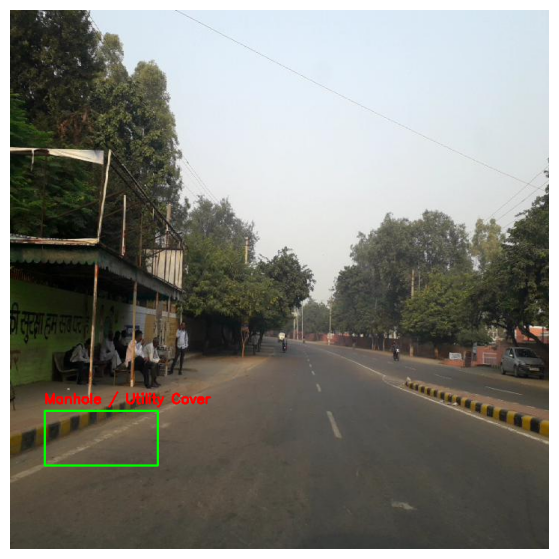

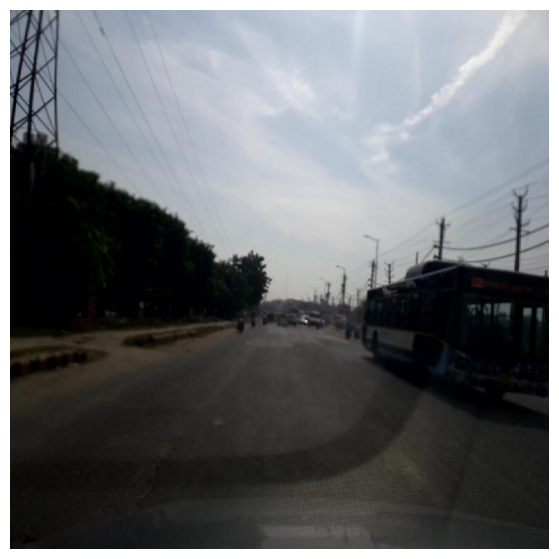

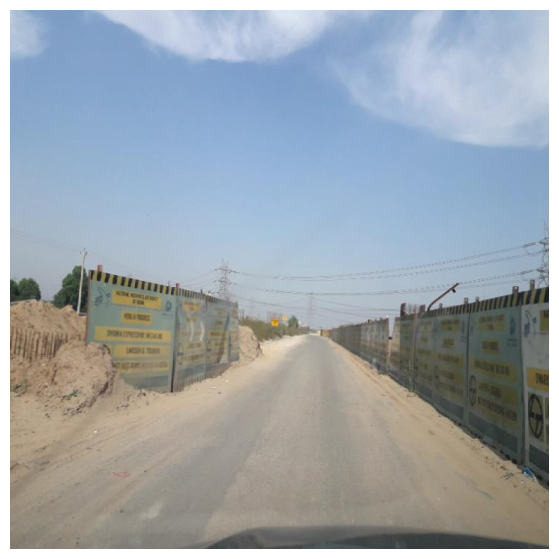

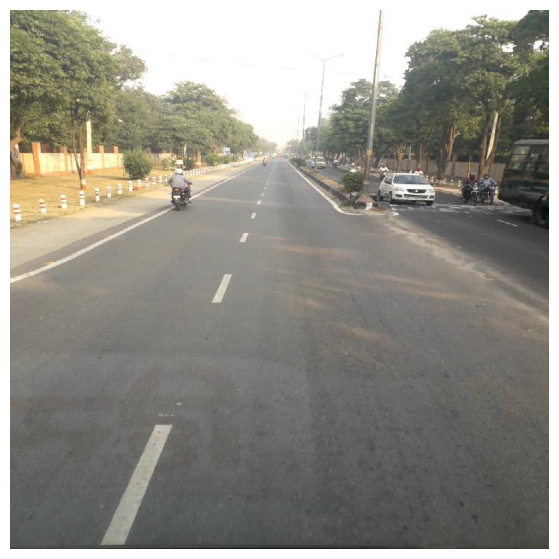

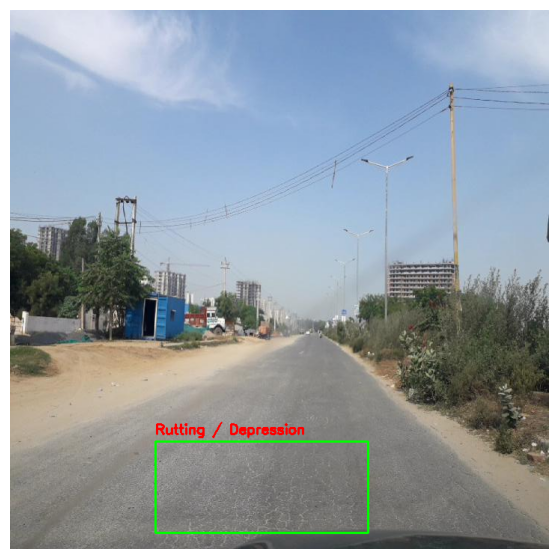

In [9]:
import random

samples = random.sample(images, 5)

for s in samples:
    visualize_sample_readable(
        os.path.join(IMG_DIR, s),
        os.path.join(ANN_DIR, s.replace(".jpg", ".xml"))
    )

# Grouping Similar Classes
| Group ID | Group Name            | Includes original classes |
| -------- | --------------------- | ------------------------- |
| 0        | **Crack**             | `D00`, `D01`, `D10`       |
| 1        | **Road Damage**       | `D20`, `D40`              |
| 2        | **Pothole**           | `D11`                     |
| 3        | **Manhole**           | `D44`                     |
| 4        | **Other Road Damage** | `D50`                     |


In [10]:
# Original RDD → Project classes
CLASS_GROUP_MAPPING = {
    # Cracks
    "D00": "Crack",
    "D01": "Crack",
    "D10": "Crack",

    # Road surface damage
    "D20": "Road Damage",   # Rutting / Depression
    "D40": "Road Damage",   # Patch / Repair

    # Standalone anomalies
    "D11": "Pothole",
    "D44": "Manhole",
    "D50": "Other Road Damage"
}

# Classes to ignore completely
IGNORED_CLASSES = {"D43", "D0w0"}

In [12]:
CLASS_NAME_TO_ID = {
    "Crack": 0,
    "Road Damage": 1,
    "Pothole": 2,
    "Manhole": 3,
    "Other Road Damage": 4
}

ID_TO_CLASS_NAME = {v: k for k, v in CLASS_NAME_TO_ID.items()}
print("Class grouping and IDs:")
for original_cls, group_name in CLASS_GROUP_MAPPING.items():
    if original_cls in IGNORED_CLASSES:
        continue
    group_id = CLASS_NAME_TO_ID[group_name]
    print(f"{original_cls:5s} -> {group_name:15s} (ID: {group_id})")

Class grouping and IDs:
D00   -> Crack           (ID: 0)
D01   -> Crack           (ID: 0)
D10   -> Crack           (ID: 0)
D20   -> Road Damage     (ID: 1)
D40   -> Road Damage     (ID: 1)
D11   -> Pothole         (ID: 2)
D44   -> Manhole         (ID: 3)
D50   -> Other Road Damage (ID: 4)


In [13]:
def map_and_filter_labels(labels, boxes):
    mapped_labels = []
    mapped_boxes = []

    for lbl, box in zip(labels, boxes):
        if lbl in IGNORED_CLASSES:
            continue

        if lbl not in CLASS_GROUP_MAPPING:
            continue

        grouped = CLASS_GROUP_MAPPING[lbl]
        mapped_labels.append(CLASS_NAME_TO_ID[grouped])
        mapped_boxes.append(box)

    return mapped_boxes, mapped_labels


In [15]:
# Verify mapping and filtering

group_counter = Counter()

for xml_file in os.listdir(ANN_DIR):
    data = parse_voc_xml(os.path.join(ANN_DIR, xml_file))
    boxes, labels = map_and_filter_labels(
        data["labels"],
        data["boxes"]
    )
    group_counter.update(labels)

print("Grouped class distribution:\n")
for cls_id, cnt in group_counter.items():
    print(f"{ID_TO_CLASS_NAME[cls_id]:20s}: {cnt}")


Grouped class distribution:

Road Damage         : 5208
Manhole             : 1062
Crack               : 1802
Pothole             : 45
Other Road Damage   : 28
